In [1]:
import os
import cv2
from  tqdm  import  tqdm 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
import random
from skimage import feature as ft
from sklearn.decomposition import PCA
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

from xgboost import XGBClassifier
import xgboost
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import NuSVC, SVC
from sklearn.linear_model import SGDClassifier

from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

import time
# 忽略警告
import warnings
warnings.filterwarnings("ignore")

E:\python\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
# 训练集图片所在路径
train_dir = 'D:/pythonProject_PlantSeedlingsClassification/plant-seedlings-classification/train/'
# 处理后的训练集图片所在路径（均衡化）
train_processed_dir = 'D:/pythonProject_PlantSeedlingsClassification/plant-seedlings-classification/train_processed/'
# 特征保存的路径
feature_dir = 'D:/pythonProject_PlantSeedlingsClassification/feature/'
# 测试集图片所在路径
test_dir = 'D:/pythonProject_PlantSeedlingsClassification/plant-seedlings-classification/test/'
# 处理后的训练集图片所在路径
test_processed_dir = 'D:/pythonProject_PlantSeedlingsClassification/plant-seedlings-classification/test_processed/'

# 图像预处理

均衡化

In [3]:
# 图像均衡化
def equalize(image):
    # 分割B,G,R （cv2读取图像的格式即为[B,G,R]，与matplotlib的[R,G,B]不同）
    b,g,r = cv2.split(image)
    # 依次均衡化
    b = cv2.equalizeHist(b)
    g = cv2.equalizeHist(g)
    r = cv2.equalizeHist(r)
    # 结合成一个图像
    equ_img = cv2.merge((b,g,r))
    
    return equ_img

提取叶子部分

In [4]:
# 提取图片中绿色（叶子）的部分
def extractGreen(image):
    # 绿色范围
    lower_green = np.array([35, 43, 46], dtype="uint8")  # 颜色下限
    upper_green = np.array([90, 255, 255], dtype="uint8")  # 颜色上限
    
    # 高斯滤波
    img_blur = cv2.GaussianBlur(image, (3, 3), 0)
    img_blur = cv2.cvtColor(img_blur, cv2.COLOR_BGR2HSV)
    # 根据阈值找到对应颜色，二值化
    mask = cv2.inRange(img_blur, lower_green, upper_green)
    
    # 掩膜函数
    output = cv2.bitwise_and(image, image, mask=mask)

    return output

图像预处理并保存到指定位置

In [5]:
# 获取并保存 均衡化及提取绿色（叶子） 及标签
def process(file_dir):
    image_list = []
    label_list = []
    name_dic = {'Black-grass': 0, 'Charlock': 1, 'Cleavers': 2, 'Common Chickweed': 3, 
                'Common wheat': 4, 'Fat Hen': 5, 'Loose Silky-bent': 6, 'Maize': 7,
                'Scentless Mayweed': 8, 'Shepherds Purse': 9, 'Small-flowered Cranesbill': 10, 'Sugar beet': 11}
    classes = os.listdir(file_dir)
    print(classes)
    
    for cls in classes:
        files = os.listdir(file_dir + cls)
        new_folder = train_processed_dir + cls
        if not os.path.exists(new_folder):
            os.makedirs(new_folder)  # 创建处理好的图片的文件夹
        for file in files:
            # 读取图片
            image = cv2.imread(file_dir + cls + '/' + file) 
            # 均衡化
            equ_img = equalize(image)
            # 提取绿色（叶子）
            img_green = extractGreen(equ_img)
            # 保存处理过的图像到新的路径
            cv2.imwrite(new_folder + '/' + file, img_green)
            # 将 处理后的图像 和 标签 加入到列表
            image_list.append(img_green)
            label_list.append(name_dic[cls])

    return image_list, label_list

resize

In [5]:
def resize(image_list):
    img_list = []
    for image in image_list:
        # 缩放成(128, 128, 3),保证所有图像的像素点数一致
        image = cv2.resize(image, (128, 128)) 
        img_list.append(image)
    return img_list

图像预处理——执行

In [7]:
# 处理所有图片，并保存到新的路径
# image_list, label_list = process(train_dir)

读取处理后的图像及标签

In [3]:
# 读取 处理后的 图片列表 和 标签列表
def read_images_processed(file_dir):
    image_list = []
    label_list = []
    name_dic = {'Black-grass': 0, 'Charlock': 1, 'Cleavers': 2, 'Common Chickweed': 3,
                'Common wheat': 4, 'Fat Hen': 5, 'Loose Silky-bent': 6, 'Maize': 7,
                'Scentless Mayweed': 8, 'Shepherds Purse': 9, 'Small-flowered Cranesbill': 10, 'Sugar beet': 11}
    classes = os.listdir(file_dir)
    
    num_per_class = []  # 记录每个种类的数量
    for cls in classes:
        files = os.listdir(file_dir + cls)
        num = 0
        for file in files:
            # 读取图片
            image = cv2.imread(file_dir + cls + '/' + file) 
            # 将 图像 和 标签 加入到列表
            image_list.append(image)
            label_list.append(name_dic[cls])
            num += 1
        num_per_class.append(num)
    print(f'每类的数量: {num_per_class}')
        
    return image_list, label_list, num_per_class

读取处理后的图片及标签

In [4]:
# 读取 处理后的 图片列表 和 标签列表
image_list, label_list, num_per_class = read_images_processed(train_processed_dir)
all_label = np.array(label_list)

[263, 390, 287, 611, 221, 475, 654, 221, 516, 231, 496, 385]


In [7]:
print(f'图像数量: {len(image_list)}')  # 4750
print(f'第一张图片的shape: {image_list[1].shape}')  # (w, h, 3)
print(f'label数量: {all_label.shape[0]}')  # 4750

4750
(388, 388, 3)
4750


保存特征矩阵到文件

In [11]:
# 将提取出的特征数组（二维）保存到npy文件中
def save_feature(feature, fileName):
    np.save(feature_dir + fileName + '.npy', feature, allow_pickle=True)
    
    print(fileName + '.npy', '文件已生成！')

从文件读取特征矩阵

In [12]:
# 读取 之前保存好的 feature文件，返回特征矩阵（二维数组）
def read_feature(fileName):
    feature = np.load(feature_dir + fileName + '.npy', allow_pickle=True)
    print('已读取', fileName, '文件！\t shape = ', feature.shape)

    return feature

# 特征处理

In [6]:
# 填充缺失值
def fill_missing(feature):
    feature_df = pd.DataFrame(feature)  # 转为DataFrame格式，才能使用fillna函数
    feature_df_fill = feature_df.fillna(0)  # 将缺失值部分填充0
    # 返回array格式
    return np.array(feature_df_fill)

In [7]:
# 标准化
def normalize(feature):
    scaler = StandardScaler()
    scaler.fit(feature)
    feature_normal = scaler.transform(feature)
    
    return feature_normal

In [8]:
# 降维 使用PCA(Principal Component Analysis)主成分分析
def dimensionalityReduction(feature, n=100, is_whiten=False, is_show=True):
    estimator = PCA(n_components=n, whiten=is_whiten)
    pca_feature = estimator.fit_transform(feature)
    
    sum = 0
    for ratio in estimator.explained_variance_ratio_:
        sum += ratio
        if is_show:
            print(sum)
    
    print('降维后特征矩阵shape为:', pca_feature.shape)
    print('主成分比例为:', sum)
    return pca_feature

由于提取出的HOG，LBP的特征维数很大，如果直接使用全部的特征矩阵作为训练集特征，训练速度很慢，且他们作为特征的占比过多，会影响到训练效果，导致准确率不高，因此需要使用主成分分析（PCA）对特征进行降维。

其中estimator.explained_variance_ratio_表示降维后每个维度能代表原先特征的占比，遍历并对其累加输出，方便确定一个好的降维维度数，使其维度不太多且能代表原先特征的较高占比，尽量减少降维所造成的特征损失。

# 提取特征

## SIFT+BOW

In [9]:
# 提取图像的SIFT特征
def sift_feature(image_list):
    feature_sift_list = []  # SIFT特征向量列表
    
    sift = cv2.xfeatures2d.SIFT_create()
    
    for i in tqdm(range(len(image_list))):
        # 转为灰度图
        image = cv2.cvtColor(image_list[i], cv2.COLOR_BGR2GRAY)
        # 获取SIFT特征，kp为关键点信息，des为关键点特征矩阵形式
        kp, des = sift.detectAndCompute(image, None)
        feature_sift_list.append(des)
        
    return feature_sift_list

In [10]:
# 初始化BOW训练器
def bow_init(feature_sift_list):
    # 创建BOW训练器，指定k-means参数k   把处理好的特征数据全部合并，利用聚类把特征词分为若干类，此若干类的数目由自己设定，每一类相当于一个视觉词汇
    bow_kmeans_trainer = cv2.BOWKMeansTrainer(100)
    
    for feature_sift in feature_sift_list:
        bow_kmeans_trainer.add(feature_sift)
    
    # 进行k-means聚类，返回词汇字典 也就是聚类中心
    voc = bow_kmeans_trainer.cluster()
    
    # 输出词汇字典
    print(voc)
    print(type(voc),voc.shape)
    
    # FLANN匹配  
    # algorithm用来指定匹配所使用的算法，可以选择的有LinearIndex、KTreeIndex、KMeansIndex、CompositeIndex和AutotuneInde
    # 这里选择的是KTreeIndex(使用kd树实现最近邻搜索)
    flann_params = dict(algorithm=1,tree=5)
    flann = cv2.FlannBasedMatcher(flann_params,{})
    
    print(flann)
    
    #初始化bow提取器(设置词汇字典),用于提取每一张图像的BOW特征描述
    sift = cv2.xfeatures2d.SIFT_create()
    bow_img_descriptor_extractor = cv2.BOWImgDescriptorExtractor(sift, flann)        
    bow_img_descriptor_extractor.setVocabulary(voc)
    
    print(bow_img_descriptor_extractor)
    
    return bow_img_descriptor_extractor

In [11]:
# 提取BOW特征
def bow_feature(bow_img_descriptor_extractor, image_list):
    # 分别对每个图片提取BOW特征，获得BOW特征列表
    feature_bow_list = [] 
    sift = cv2.xfeatures2d.SIFT_create()
    for i in tqdm(range(len(image_list))):
        image = cv2.cvtColor(image_list[i], cv2.COLOR_BGR2GRAY)
        feature_bow = bow_img_descriptor_extractor.compute(image,sift.detect(image))
        feature_bow_list.append(feature_bow)
    return np.array(feature_bow_list)[:,0,:]

In [23]:
# 获取SIFT特征列表
feature_sift_list = sift_feature(image_list)

100%|██████████| 4750/4750 [08:54<00:00,  8.88it/s] 


In [27]:
print(len(feature_sift_list))  # 4750
print(feature_sift_list[0])
# 以下3个输出为sift特征的 shape, 为 (关键点数量, 128)
print(feature_sift_list[0].shape)  # (?, 128)
print(feature_sift_list[1].shape)  # (?, 128)
print(feature_sift_list[100].shape)  # (?, 128)

4750
[[38.  1.  0. ...  0.  0.  0.]
 [ 1.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 ...
 [ 1.  0.  1. ...  0.  0.  0.]
 [69.  6.  0. ...  0.  0.  0.]
 [ 2.  0.  0. ...  0.  0.  0.]]
(69, 128)
(122, 128)
(36, 128)


In [28]:
# 获取 SIFT + BOW 特征

# # 从图像中提取 并 保存在npy文件中
bow_extractor = bow_init(feature_sift_list)
all_feature_bow = bow_feature(bow_extractor, image_list)  # shape = (4750, 100)
# save_feature(all_feature_bow, 'all_feature_bow')

[[  3.23646     2.5354166   2.9468896 ...   8.294176    6.177986
   10.398415 ]
 [  3.6385617   3.4220266   4.648721  ...   2.4211638   3.2540011
    3.4607654]
 [  1.6569123   1.0533681   1.8216127 ...   4.8039937   3.3299115
   10.079925 ]
 ...
 [103.444084   27.049927    2.9411678 ...  25.427517    2.358686
    2.0369341]
 [ 13.368217   13.152087   19.814342  ...  17.20656    17.835737
   18.438665 ]
 [  6.9729743   6.577491    6.046719  ...  14.695922    3.2169003
    3.6252275]]
<class 'numpy.ndarray'> (100, 128)
<FlannBasedMatcher 00000228F94549B0>
<BOWImgDescriptorExtractor 00000228F9542BB0>


## HOG

In [22]:
# 所有图片resize成(128,128)，保证每个图像提取出的HOG，LBP特征数量一致
# 提取HOG，LBP特征前调用
image_list = resize(image_list)

In [23]:
# 提取HOG特征
def hog_feature(image_list):
    feature_hog_list = []
    for i in tqdm(range(len(image_list))):
        feature_hog = ft.hog(image_list[i], orientations=16, pixels_per_cell=(32, 32), cells_per_block=(3, 3), 
                             feature_vector=True, multichannel=True)
        feature_hog_list.append(feature_hog)
    
    return np.array(feature_hog_list)

In [24]:
# 获取 HOG 特征

# # 从图像中提取 并 保存在csv文件中
all_feature_hog = hog_feature(image_list)
# print('all_feature_hog.shape =', all_feature_hog.shape)
# save_feature(all_feature_hog, 'all_feature_hog')

## LBP

In [25]:
# 提取LBP特征
def lbp_feature(image_list):
    feature_lbp_list = []
    for j in tqdm(range(len(image_list))):
        feature_lbp = []
        image = image_list[j]
        for i in range(3):
            feature_lbp.append(ft.local_binary_pattern(np.array(image[:,:,i]), 64, 64, 'var'))
        feature_lbp_list.append(feature_lbp)
    return np.array(feature_lbp_list)

In [26]:
# 获取 LBP 特征

# # 从图像中提取 & 填充缺失值 & 保存在npy文件中
# all_feature_lbp = lbp_feature(image_list)  # shape = (4750, 3, 128, 128)
# print(np.array(all_feature_lbp).shape)  # (4750, 3, 128, 128)
# # 将四维转为二维

# all_feature_lbp = all_feature_lbp.reshape(all_feature_lbp.shape[0], 
#                                           all_feature_lbp.shape[1] * all_feature_lbp.shape[2] * all_feature_lbp.shape[3])
# print('all_feature_lbp.shape =', all_feature_lbp.shape)  # (4750, 49152)
# # 填充缺失值
# all_feature_lbp = fill_missing(all_feature_lbp)  
# save_feature(all_feature_lbp, 'all_feature_lbp')

读取提取过的特征（未处理）

In [27]:
# # 从保存的npy文件中读取
# all_feature_bow = read_feature('all_feature_bow')

# # 从保存的npy文件中读取 全部
# all_feature_hog = read_feature('all_feature_hog')

# # 从保存的npy文件中读取 全部
# all_feature_lbp = read_feature('all_feature_lbp')

标准化——执行

In [28]:
# all_feature_bow_normal = normalize(all_feature_bow)
# save_feature(all_feature_bow_normal, 'all_feature_bow_normal')

In [29]:
# all_feature_hog_normal = normalize(all_feature_hog)
# save_feature(all_feature_hog_normal, 'all_feature_hog_normal')

In [30]:
# all_feature_lbp_normal = normalize(all_feature_lbp)
# save_feature(all_feature_lbp_normal, 'all_feature_lbp_normal')

降维——执行

In [31]:
# 降维
# print('all_feature_bow.shape =', all_feature_bow.shape)  # all_feature_hog.shape = (4750, 100)
# pca_feature_bow = dimensionalityReduction(all_feature_bow, 100)
# save_feature(pca_feature_bow, 'pca_feature_bow')

# print('all_feature_hog.shape =', all_feature_hog.shape)  # all_feature_hog.shape = (4750, 2916)
# pca_feature_hog = dimensionalityReduction(all_feature_hog, 60) 
# save_feature(pca_feature_hog, 'pca_feature_hog')

# print('all_feature_lbp.shape =', all_feature_lbp.shape)  # all_feature_lbp.shape = (4750, 49152)
# pca_feature_lbp = dimensionalityReduction(all_feature_lbp, 100, True)
# save_feature(pca_feature_lbp, 'pca_feature_lbp')

读取特征（处理后的）

In [32]:
# 从保存的npy文件中读取
all_feature_bow_normal = read_feature('all_feature_bow_normal')

# 从保存的npy文件中读取 降维后的
pca_feature_hog = read_feature('pca_feature_hog')

# 从保存的npy文件中读取 降维后的
pca_feature_lbp = read_feature('pca_feature_lbp')

已读取 all_feature_bow_normal 文件！	 shape =  (4750, 100)
已读取 pca_feature_hog 文件！	 shape =  (4750, 60)
已读取 pca_feature_lbp 文件！	 shape =  (4750, 100)


网格搜索 寻找最优降维占比

In [33]:
# 网格搜索 最优降维占比
def grid_search(feature, ratio_list):
    score_list = []
    for ratio in ratio_list:
        pca_feature = dimensionalityReduction(feature, ratio, is_show=False)
        
        sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
        sss.get_n_splits(pca_feature, all_label)
        for train_index, val_index in sss.split(pca_feature, all_label):
            x_train, x_val = pca_feature[train_index], pca_feature[val_index]
            y_train, y_val = all_label[train_index], all_label[val_index]
        
        # LGBM模型
        tmp_model_lgb = lgb.LGBMClassifier(learning_rate=0.1, objective='multiclass', num_class=12, n_estimators=1000, max_depth=2)
        # 训练 early_stopping_rounds表示提前结束训练，避免过拟合，这里设置为测试误差10次不再下降便结束训练
        tmp_model_lgb.fit(x_train, y_train, early_stopping_rounds=10, eval_set=[(x_val, y_val)], eval_metric ='logloss', verbose=False)
        score = tmp_model_lgb.score(x_val, y_val)
        print('ratio =', ratio, ', score =', score, '\n')
        score_list.append(score)
    
    index = score_list.index(max(score_list))
    return ratio_list[index]

In [34]:
# ratio_bow_list = np.linspace(0.7, 1.0, num=6, endpoint=False)
# print(ratio_bow_list)
# best_ratio_bow = grid_search(all_feature_bow, ratio_hog_list)
# print(best_ratio_hog)
# pca_feature_bow = dimensionalityReduction(all_feature_bow, best_ratio_bow)

In [35]:
# ratio_hog_list = np.linspace(0.9, 1.0, num=10, endpoint=False)
# print('ratio_hog_list =', ratio_hog_list)
# best_ratio_hog = grid_search(all_feature_hog, ratio_hog_list)
# print('best_ratio_hog =', best_ratio_hog)

In [36]:
# ratio_lbp_list = np.linspace(0.8, 0.95, num=4)
# print(ratio_lbp_list)
# best_ratio_lbp = grid_search(all_feature_lbp, ratio_lbp_list)
# print(best_ratio_lbp)

# 特征拼合

In [37]:
# 将SIFT+BOW, HOG, LBP 三种特征矩阵拼合到一起
all_feature_list = [all_feature_bow_normal, pca_feature_hog, pca_feature_lbp]
all_feature = [[] for i in range(4750)]  # 创建二维空数组，行数为4750

for feature in all_feature_list:
    all_feature = np.hstack((all_feature, feature))
    
print(all_feature.shape)

np.save(feature_dir + 'all_feature', all_feature, allow_pickle=True)

(4750, 260)


# 训练模型

## 分层划分数据集

In [38]:
# 按类划分数据集
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
sss.get_n_splits(all_feature, all_label)
for train_index, test_index in sss.split(all_feature, all_label):
    x_train, x_val = all_feature[train_index], all_feature[test_index]
    y_train, y_val = all_label[train_index], all_label[test_index]

print(x_train.shape, x_val.shape, y_train.shape, y_val.shape)

(3800, 260) (950, 260) (3800,) (950,)


   train_test_split()函数划分数据集是将所有数据同一划分训练集和验证集，这大概率会导致每一类数据在训练集和验证集的比例是不同的，数据集划分不平衡会导致训练模型时对于某一类的训练效果很好，而对另一类的训练效果很差，即出现了过拟合和欠拟合的情况。
   <br>
   使用StratifiedShuffleSplit()函数将数据集“按类”划分训练集和验证集，保证每一类训练集和验证集的比例是相同的，有效降低了过拟合和欠拟合情况的出现。

In [39]:
num_class_train = np.zeros(12, dtype=np.int64)
num_class_val = np.zeros(12, dtype=np.int64)
for y in y_train:
    num_class_train[y] += 1
for y in y_val:
    num_class_val[y] += 1
print('划分后训练集中各类的数量 =', num_class_train)
print('数据集中各类的数量 * 0.8 =', [round((i * 0.8), 1) for i in num_per_class])
print('划分后验证集中各类的数量 =', num_class_val)
print('数据集中各类的数量 * 0.2 =', [round((i * 0.2), 1) for i in num_per_class])

划分后训练集中各类的数量 = [210 312 229 489 177 380 523 177 413 185 397 308]
数据集中各类的数量 * 0.8 = [210.4, 312.0, 229.6, 488.8, 176.8, 380.0, 523.2, 176.8, 412.8, 184.8, 396.8, 308.0]
划分后验证集中各类的数量 = [ 53  78  58 122  44  95 131  44 103  46  99  77]
数据集中各类的数量 * 0.2 = [52.6, 78.0, 57.4, 122.2, 44.2, 95.0, 130.8, 44.2, 103.2, 46.2, 99.2, 77.0]


从上面的输出可以看出训练集与验证集的划分是符合“按类”分类的。

## 训练模型

In [40]:
# 展示各类的准确率、召回率、f1-score，及混淆矩阵可视化
def category_show(model, x_val, y_val):
    target_names = ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed','Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize',
                    'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']
    y_pred = model.predict(x_val)
    print(classification_report(y_val, y_pred, target_names=target_names))
    cm = confusion_matrix(y_val, y_pred)
    cm_display = ConfusionMatrixDisplay(cm).plot()

In [41]:
# XGBoost模型
start = time.time()
model_xgb = XGBClassifier(learning_rate=0.1, objective='multi:softmax', num_class=12, n_estimators=500, tree_method='gpu_hist', gpu_id=0,
                          max_depth=3, min_child_weight=2, max_delta_step=3, subsample=0.7, gamma=0, n_jobs=-1,
                          use_label_encoder=False)
# 训练 early_stopping_rounds表示提前结束训练，避免过拟合，这里设置为测试误差10次不再下降便结束训练
model_xgb.fit(x_train, y_train, early_stopping_rounds=10, eval_set=[(x_val, y_val)], 
              eval_metric='mlogloss', verbose=50)
score_xgb = model_xgb.score(x_val, y_val)
print('score_xgb =', score_xgb)
print("Train time: {0}".format(time.time() - start))

[0]	validation_0-mlogloss:2.30737
[50]	validation_0-mlogloss:0.65294
[100]	validation_0-mlogloss:0.47186
[150]	validation_0-mlogloss:0.40570
[200]	validation_0-mlogloss:0.37587
[250]	validation_0-mlogloss:0.36152
[300]	validation_0-mlogloss:0.35271
[345]	validation_0-mlogloss:0.35108
score_xgb = 0.8852631578947369
Train time: 16.2021644115448


In [50]:
import joblib
joblib.dump(model_xgb, 'model_xgb.model')
model_xgb = joblib.load('model_xgb.model')

In [51]:
score_xgb = model_xgb.score(x_val, y_val)
print('score_xgb =', score_xgb)

score_xgb = 0.8852631578947369


                           precision    recall  f1-score   support

              Black-grass       0.84      0.60      0.70        53
                 Charlock       0.90      0.97      0.94        78
                 Cleavers       0.91      0.90      0.90        58
         Common Chickweed       0.87      0.93      0.90       122
             Common wheat       0.85      0.77      0.81        44
                  Fat Hen       0.92      0.86      0.89        95
         Loose Silky-bent       0.85      0.96      0.90       131
                    Maize       0.93      0.86      0.89        44
        Scentless Mayweed       0.80      0.91      0.85       103
          Shepherds Purse       0.88      0.65      0.75        46
Small-flowered Cranesbill       0.94      0.98      0.96        99
               Sugar beet       0.97      0.87      0.92        77

                 accuracy                           0.89       950
                macro avg       0.89      0.86      0.87    

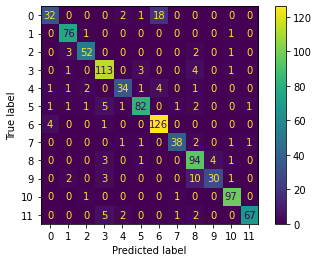

In [42]:
category_show(model_xgb, x_val, y_val)

In [43]:
# LightGBM模型
model_lgb = lgb.LGBMClassifier(learning_rate=0.1, objective='multiclass', num_class=12, n_estimators=500, max_depth=3, 
                               sub_sample=0.7, n_jobs=-1)
model_lgb.fit(x_train, y_train, early_stopping_rounds=10, eval_set=[(x_val, y_val)], eval_metric ='logloss', verbose=10)
score_lgb = model_lgb.score(x_val, y_val)
print('score_lgb =', score_lgb)

[LightGBM] [Warning] Unknown parameter: sub_sample
[10]	valid_0's multi_logloss: 1.08571
[20]	valid_0's multi_logloss: 0.777077
[30]	valid_0's multi_logloss: 0.636966
[40]	valid_0's multi_logloss: 0.558904
[50]	valid_0's multi_logloss: 0.514409
[60]	valid_0's multi_logloss: 0.4791
[70]	valid_0's multi_logloss: 0.453618
[80]	valid_0's multi_logloss: 0.434917
[90]	valid_0's multi_logloss: 0.420478
[100]	valid_0's multi_logloss: 0.413203
[110]	valid_0's multi_logloss: 0.403179
[120]	valid_0's multi_logloss: 0.396644
[130]	valid_0's multi_logloss: 0.393972
[140]	valid_0's multi_logloss: 0.39246
score_lgb = 0.8726315789473684


                           precision    recall  f1-score   support

              Black-grass       0.83      0.57      0.67        53
                 Charlock       0.93      0.95      0.94        78
                 Cleavers       0.93      0.88      0.90        58
         Common Chickweed       0.87      0.91      0.89       122
             Common wheat       0.89      0.75      0.81        44
                  Fat Hen       0.89      0.85      0.87        95
         Loose Silky-bent       0.83      0.95      0.89       131
                    Maize       0.93      0.91      0.92        44
        Scentless Mayweed       0.78      0.91      0.84       103
          Shepherds Purse       0.88      0.61      0.72        46
Small-flowered Cranesbill       0.93      0.99      0.96        99
               Sugar beet       0.90      0.83      0.86        77

                 accuracy                           0.87       950
                macro avg       0.88      0.84      0.86    

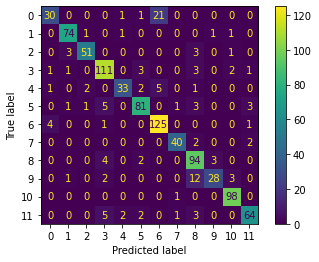

In [44]:
category_show(model_lgb, x_val, y_val)

In [45]:
# GBDT模型
# model_gbdt = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100, max_depth=3)
# model_gbdt.fit(x_train, y_train)
# score_gbdt = model_gbdt.score(x_val, y_val)
# print('score_gbdt =', score_gbdt)

KeyboardInterrupt: 

In [ ]:
# category_show(model_gbdt, x_val, y_val)

In [ ]:
# RandomForest模型
start = time.time()
model_rf = RandomForestClassifier(n_estimators=150, n_jobs=-1)
model_rf.fit(x_train, y_train)
score_rf = model_rf.score(x_val, y_val)
print('score_rf =', score_rf)
print("Train time: {0}".format(time.time() - start))

In [ ]:
category_show(model_rf, x_val, y_val)

In [ ]:
model_SVC = SVC(C=1)
model_SVC.fit(x_train, y_train)
score_SVC = model_SVC.score(x_val, y_val)
print('score_SVC =', score_SVC)

In [ ]:
category_show(model_SVC, x_val, y_val)

In [ ]:
model_knn = KNeighborsClassifier(n_neighbors=1)
model_knn.fit(x_train, y_train)
score_knn = model_knn.score(x_val, y_val)
print('score_knn =', score_knn)

In [ ]:
category_show(model_knn, x_val, y_val)

In [ ]:
model_sgdc = SGDClassifier(max_iter=1000, tol=1e-3)
model_sgdc.fit(x_train, y_train)
score_sgdc = model_sgdc.score(x_val, y_val)
print('score_sgdc =', score_sgdc)

In [ ]:
category_show(model_sgdc, x_val, y_val)

In [ ]:
model_ET = ExtraTreesClassifier()
model_ET.fit(x_train, y_train)
score_ET = model_ET.score(x_val, y_val)
print('score_ET =', score_ET)

In [ ]:
category_show(model_ET, x_val, y_val)

In [ ]:
estimators = [
    ('rf', model_rf),
    ('lgb', lgb.LGBMClassifier(learning_rate=0.1, objective='multiclass', num_class=12, n_estimators=150, max_depth=2, n_jobs=-1)),
    ('SVC', model_SVC),
    ('SGDC', model_sgdc),
    ('ET', model_ET)
]
model_stack = StackingClassifier(
    estimators=estimators, final_estimator= XGBClassifier(learning_rate=0.1, objective='multi:softmax', num_class=12, n_estimators=300, 
                                                          tree_method='gpu_hist', gpu_id=0, max_depth=3, min_child_weight=3, 
                                                          max_delta_step=3, subsample=0.7, gamma=0, n_jobs=-1, use_label_encoder=False)
)
model_stack.fit(x_train, y_train)
score_stack = model_stack.score(x_val, y_val)
print('score_stack =', score_stack)

In [ ]:
category_show(model_stack, x_val, y_val)

In [ ]:
# 获取各个模型对每张图片每类的预测概率
target_names = ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed','Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize',
                    'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']
y_predict_xgb_proba = model_xgb.predict_proba(x_val)
y_predict_lgb_proba = model_lgb.predict_proba(x_val)
y_predict_rf_proba = model_rf.predict_proba(x_val)
# y_predict_SVC_proba = model_SVC.predict_proba(x_val)
# y_predict_sgdc_proba = model_sgdc.predict_proba(x_val)
y_predict_ET_proba = model_ET.predict_proba(x_val)

# 将概率线性相加，得到混合模型的预测概率
y_predict_proba = y_predict_xgb_proba * 0.3 + y_predict_lgb_proba * 0.3 + y_predict_rf_proba * 0.3 + y_predict_ET_proba * 0.1
                  
y_pre_mix = []
num_correct = 0
for proba, label in zip(y_predict_proba, y_val):
    y_pre = np.argmax(proba)
    y_pre_mix.append(y_pre)
    if y_pre == label:
        num_correct += 1
score_linearAdd = num_correct / len(y_val)
print('score_linearAdd =', score_linearAdd)

print(classification_report(y_val, y_pre_mix, target_names=target_names))

网格搜索模型调参

In [ ]:
# param_test1 = {'n_estimators':range(60,201,20)}
# gsearch1 = GridSearchCV(estimator = RandomForestClassifier(n_jobs=-1, random_state=10), 
#                        param_grid = param_test1, scoring='roc_auc',cv=5)
# grid_result = gsearch1.fit(x_train, y_train)

# 交叉验证

In [ ]:
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
scores = cross_val_score(model_stack, all_feature, all_label, cv=cv)
print('scores =', scores)
print('平均准确率 =', np.mean(scores))

In [ ]:
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
cv.get_n_splits(all_feature, all_label)
for train_index, test_index in cv.split(all_feature, all_label):
    x_train, x_val = all_feature[train_index], all_feature[test_index]
    y_train, y_val = all_label[train_index], all_label[test_index]
    y_pred = model_stack.predict(x_val)
    print(classification_report(y_val, y_pred, target_names=target_names))
    break

------------------------------------------------------下面是测试输出特征------------------------------------------------------

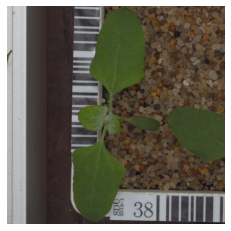

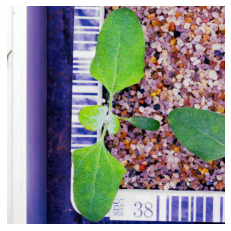

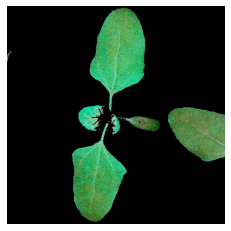

(<matplotlib.image.AxesImage at 0x2290a6b8070>,
 (-0.5, 1028.5, 1028.5, -0.5),
 None)

In [12]:
# 测试 均衡化+提取绿色
tmp_img = cv2.imread(r'D:\pythonProject_PlantSeedlingsClassification\plant-seedlings-classification\train\Fat Hen\0f335c7a7.png')
tmp_equ_img = equalize(tmp_img)
tmp_img_green = extractGreen(tmp_equ_img)

b,g,r = cv2.split(tmp_img)
tmp_img_rgb = cv2.merge((r,g,b))
b,g,r = cv2.split(tmp_equ_img)
tmp_equ_img_rgb = cv2.merge((r,g,b))

plt.imshow(tmp_img_rgb),plt.axis('off'),plt.show()
plt.imshow(tmp_equ_img_rgb),plt.axis('off'),plt.show()
plt.imshow(tmp_img_green),plt.axis('off'),plt.show()

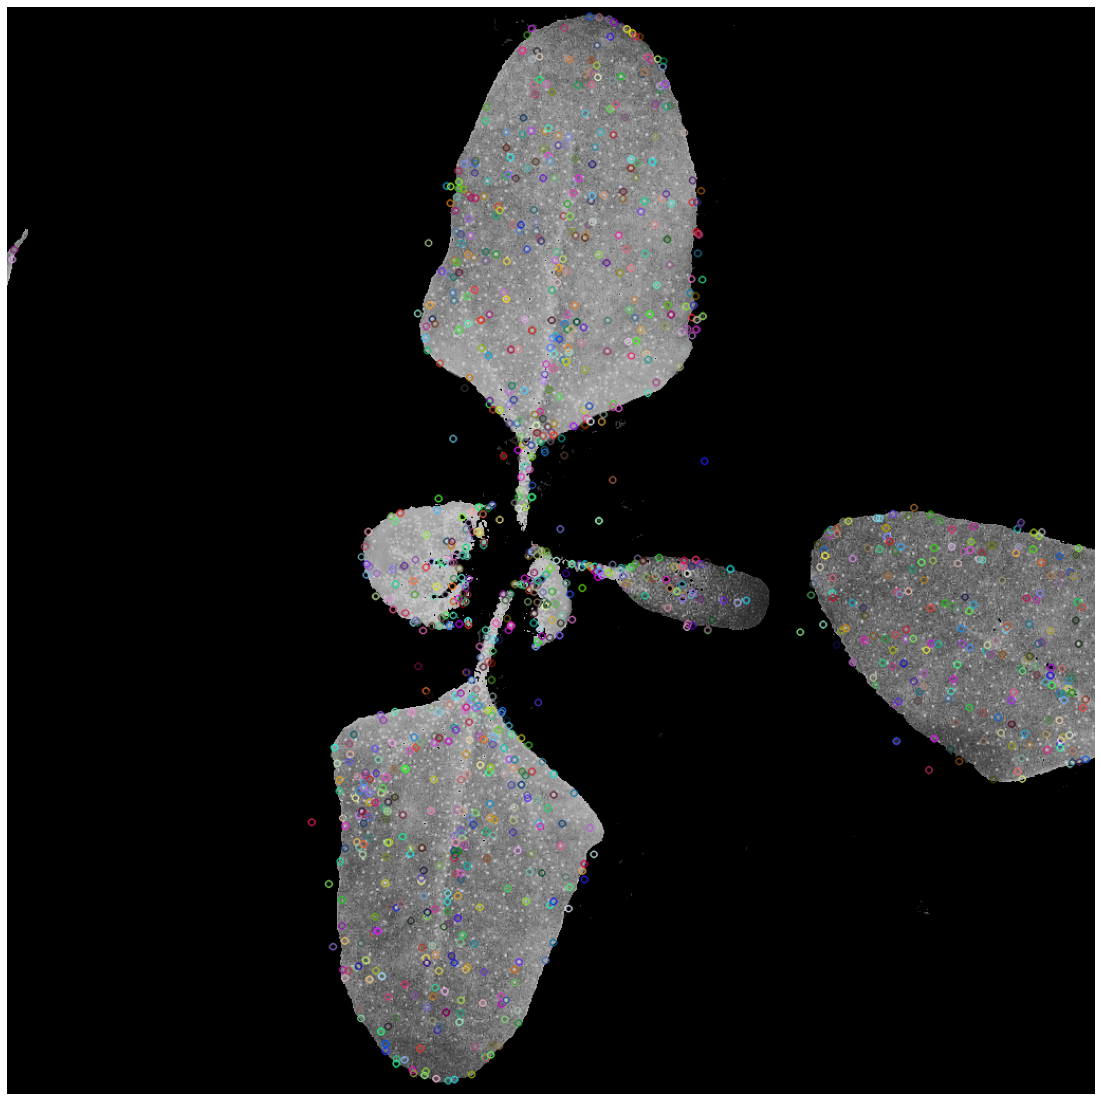

kp[0] = <KeyPoint 000002290A9FC450>
len(kp) = 1323
des.shape = (1323, 128)


In [13]:
# 测试 SIFT
sift = cv2.xfeatures2d.SIFT_create()

img_gray = cv2.cvtColor(tmp_img_green, cv2.COLOR_BGR2GRAY)

kp = sift.detect(img_gray, None) #  找到关键点

# 绘制关键点 
# tmp_img_gray输入图片, kp表示关键点，tmp_img_sift输出图片
img_gray = cv2.drawKeypoints(img_gray, kp, img_gray)

# 计算关键点对应的sift特征向量
# kp为关键点列表，des为numpy的数组，为 (关键点数目,128)
kp, des = sift.compute(img_gray, kp)

plt.figure(figsize=(20,20))
plt.imshow(img_gray),plt.axis('off'),plt.show()
print('kp[0] =', kp[0])
print('len(kp) =', len(kp))
print('des.shape =', des.shape)

In [ ]:
# # 测试 SIFT + BOW 单个图片的特征
# print(all_feature_bow[0])

In [ ]:
tmp_img_green = resize([tmp_img_green])[0]

In [ ]:
# 测试 提取图像的HOG特征
feature_hog = ft.hog(tmp_img_green, orientations=16, pixels_per_cell=(32, 32), cells_per_block=(3, 3), 
                     feature_vector=True, multichannel=True, visualize=True)
print(feature_hog[0].shape[0])
plt.imshow(feature_hog[1], cmap=plt.cm.gray),plt.axis('off'),plt.show()

In [ ]:
# 提取图像的LBP特征 测试
feature_lbp = []
for i in range(3):
    feature_lbp.append(ft.local_binary_pattern(tmp_img_green[:,:,i], 64, 64, 'var'))
print(feature_lbp)
print(np.array(feature_lbp).shape)

In [ ]:
# 测试 获取单个积分图像 
def integral_test(image):
    img_ori = image
    
    img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    #积分图像比原始图像多一行一列，积分图像第一行第一列为0
    img_integral = np.zeros(shape=(img.shape[0]+1, img.shape[1]+1), dtype=np.int32)
    for i in range(1, img.shape[0]):
        for j in range(1, img.shape[1]):
            img_integral[i][j] = img[i][j] + img_integral[i-1][j] + img_integral[i][j-1] - img_integral[i-1][j-1]
    
    plt.figure()
#     fig, axes = plt.subplots(1, 3, figsize=(10, 10))
#     axes[0].imshow(img_ori)
#     axes[1].imshow(img, cmap='gray')
#     axes[2].imshow(img_integral, cmap='gray')
#     plt.imshow()
    plt.imshow(img_integral, cmap='gray')
    plt.axis('off')
    return img_integral

img_integral = integral_test(tmp_img_green)
print(tmp_img_green.shape)
print(img_integral.shape)

In [ ]:
# 获取积分图像
def integral(image):
    # 转为灰度图
    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # 积分图像比原始图像多一行一列，积分图像第一行、第一列为0
    img_integral = np.zeros(shape=(img_gray.shape[0] + 1, img_gray.shape[1] + 1), dtype=np.int32)
    for i in range(1, img_gray.shape[0]):
        for j in range(1, img_gray.shape[1]):
            img_integral[i][j] = img_gray[i][j] + img_integral[i-1][j] + img_integral[i][j-1] - img_integral[i-1][j-1]
    
    return img_integral

In [ ]:
# 获取单一尺度的Haar特征
def haar_onescale(img, img_integral, haarblock_heigh=24, haarblock_width=24):
    # 步长为1， no padding
    haarimg = np.zeros(shape=(img.shape[0] - haarblock_heigh + 1, img.shape[1] - haarblock_width + 1), dtype=np.int32)
    haar_feature_onescale = []
    for i in range(haarimg.shape[0]):
        for j in range(haarimg.shape[1]):
            # i,j映射回原图形的坐标
            m = haarblock_heigh + i
            n = haarblock_width + i
            haar_all = img_integral[m][n] - img_integral[m - haarblock_heigh][n] - img_integral[m][n - haarblock_width] + \
                       img_integral[m - haarblock_heigh][n - haarblock_width]
            haar_black = img_integral[m][n - int(haarblock_width / 2)] + img_integral[m - haarblock_heigh][n - haarblock_width] - \
                         img_integral[m - haarblock_heigh][n - int(haarblock_width / 2)] - img_integral[m][n - haarblock_width] 
            # 1*all - 2*black = white - black
            haarimg[i][j] = 1 * haar_all - 2 * haar_black
            haar_feature_onescale.append(haarimg[i][j])
    plt.imshow(haarimg, cmap='gray')
    plt.show()
    print('当前尺度下的Haar特征维度为：{}'.format(len(haar_feature_onescale)))

    return haar_feature_onescale

In [ ]:
haar_feature_onescale = haar_onescale(tmp_img_green, img_integral)

In [ ]:
#获取全尺度下的Haar特征
def harr(img, haarblock_width, haarblock_height, Scale_num):
    feature = []
    haar_num = 0
    for i in range(Scale_num):
        haarblock_width = i*haarblock_width + 24
        haarblock_height = i*haarblock_height + 24
#         print('当前 Haarblock 尺度为: ({}, {})'.format(haarblock_height, haarblock_width)) 
        haar_feature_onescale = haar_onescale(img, integral(img), haarblock_width, haarblock_height)
        haar_num += len(haar_feature_onescale) 
        feature.append(haar_feature_onescale)
        haarblock_width = 24
        haarblock_height = 24
    #计算总的Haar特征维度
#     print( '[INFO] 计算Haar特征维数' )
#     print( 'Haar特征总的维度为：{}'.format(haar_num))
    return feature

In [ ]:
# 提取Haar特征
def haar_feature(image_list):
    #确定Haarblock的大小
    haarblock_width = 24
    haarblock_height = 24
    width_limt = int(128 / haarblock_width)
    height_limt = int(128 / haarblock_height)
    print( '--行方向尺度个数为: {}, 列方向尺度个数为： {}'.format(width_limt, height_limt))
    #可获取的尺度数量
    Scale_num = min( height_limt, width_limt )
    print( '--可用尺度个数为： {}'.format( Scale_num ) )
    print( '\n[INFO] 提取图像Haar特征' )
    
    feature_haar_list = []
    i = 0
    for image in image_list:
        if i % 10 == 0:
            print(i)
        feature_haar = harr(image, haarblock_width, haarblock_height, Scale_num)
        feature_haar_oneRow = []
        for haar_ft_i in feature_haar:
            feature_haar_oneRow = np.hstack((feature_haar_oneRow, haar_ft_i))
        feature_haar_oneRow = np.array(feature_haar_oneRow).reshape(1,22005)
        feature_haar_list.append(feature_haar_oneRow)
        i += 1
    
    return np.array(feature_haar_list)[:,0,:]

In [ ]:
all_feature_haar = haar_feature([tmp_img_green])  # shape = (4750, 22005)